In [ ]:
!pip install -q -U keras-tuner # ML experiments aka hyparam tuning 

     |████████████████████████████████| 96 kB 4.2 MB/s 


In [32]:
# Utility function 
def prepare_image(img_path, img_size = 224):
   img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
   img_array = tf.keras.preprocessing.image.img_to_array(img)
   img_array_expanded_dims = np.expand_dims(img_array, axis=0)
   return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [63]:
import numpy as np  
import tensorflow as tf 
from tensorflow.keras.metrics import Precision , Recall 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler    
from tensorflow.keras.layers import Dense, Embedding, Input , Dropout, Conv1D , MaxPooling1D, Flatten , GlobalAveragePooling2D , Concatenate , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler , ModelCheckpoint
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import classification_report
tf.random.set_seed(23)

In [2]:

train_ds_labeled = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/MSBA/BA885/data/train',
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32,
  label_mode='categorical'
)


val_ds_labeled = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/MSBA/BA885/data/val',
  validation_split=0.5,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=32, 
  label_mode='categorical')


Found 14034 files belonging to 6 classes.
Using 7017 files for training.
Found 3000 files belonging to 6 classes.
Using 1500 files for validation.


In [ ]:
def model_builder(hp):
        # Here we are defining what variables to go through in search space. 

        vgg19 = tf.keras.applications.vgg19.VGG19(input_shape=(224,224,3),
                  include_top=False, weights='imagenet')
        vgg19.trainable = False 
        # Hyperparameters that we are going to tune 

        hp_units = hp.Int('units',min_value=256,max_value=1024,step=128)
        hp_units2 = hp.Int('units2',min_value=256,max_value=1024,step=128)
        hp_units3 = hp.Int('units3',min_value=256,max_value=1024,step=128)
        
        
        hp_dropout = hp.Float('rate',min_value=.1,max_value=.6,step=.1)
        hp_dropout2 = hp.Float('rate2',min_value=.1,max_value=.6,step=.1)
      
        hp_activation1 = hp.Choice('activation',['relu','elu','selu'])
        hp_activation2 = hp.Choice('activation1',['relu','elu','selu'])
        hp_activation3 = hp.Choice('activation2',['relu','elu','selu'])
        hp_optimizer = hp.Choice('optimizers',['adam','rmsprop'])

        # model`` 
        input1  = Input((224,224,3))
        vgg19 = vgg19(input1)
        flat = Flatten()(vgg19)
        dense1 = Dense(hp_units,activation=hp_activation1)(flat)
        dropout = Dropout(hp_dropout)(dense1)
        dense2 = Dense(hp_units2,activation=hp_activation2)(dropout)
        dropout2 = Dropout(hp_dropout2)(dense2)
        dense3 = Dense(hp_units3,activation=hp_activation3)(dropout2)
        output = Dense(6,activation='softmax')(dense3)

        model = Model(inputs=[input1],outputs=[output])
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=hp_optimizer,
                    metrics=['accuracy'])

        return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                        objective='accuracy',
                        max_epochs=1000,
                        factor=3,
                        directory=r'/content/drive/MyDrive/MSBA/BA885/ml-exp',
                        project_name='project')

tuner.search(train_batches,epochs=1000,batch_size=128,callbacks=[EarlyStopping(monitor='accuracy',mode='max',patience=100),LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/1000))])

Trial 35 Complete [00h 04m 47s]
accuracy: 0.7790738940238953

Best accuracy So Far: 0.8303651213645935
Total elapsed time: 03h 50m 29s

Search: Running Trial #36

Hyperparameter    |Value             |Best Value So Far 
units             |464               |80                
units2            |272               |336               
units3            |464               |208               
rate              |0.4               |0.1               
rate2             |0.3               |0.1               
activation        |relu              |selu              
activation1       |selu              |elu               
activation2       |selu              |selu              
optimizers        |adam              |adam              
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |6                 |6                 
tuner/round       |0                 |0                 

Epoch 1/2
29/88 [========>............

In [ ]:
import os
len(os.listdir('/content/drive/MyDrive/MSBA/BA885/ml-exp/project'))

130

In [4]:
 vgg19 = tf.keras.applications.vgg19.VGG19(input_shape=(224,224,3),
                  include_top=False, weights='imagenet')

In [7]:
input  = Input((224,224,3))
x = tf.keras.layers.RandomRotation(0.1)(input) #fraction of 2pi
x = tf.keras.layers.RandomFlip("horizontal")(x)
x = vgg19(x,training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(80,activation='selu')(x)
x = Dropout(.1)(x)
x = Dense(336,activation='elu')(x)
x = Dropout(.3)(x)
x = Dense(208,activation='selu')(x)
output = Dense(6,activation='softmax')(x)

model2 = Model(inputs=[input],outputs=[output])
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer='adam',
            metrics=['accuracy'])
history = model2.fit(train_ds_labeled,epochs=20,validation_data=val_ds_labeled,callbacks=[EarlyStopping(monitor='accuracy',mode='max',patience=3),LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/1000)),
                                                                               ModelCheckpoint('best_model.pb', monitor='val_accuracy', mode='max', save_best_only=True)])

Epoch 1/20
220/220 [==============================] - 136s 557ms/step - loss: 1.0591 - accuracy: 0.5574 - val_loss: 0.7182 - val_accuracy: 0.7033
INFO:tensorflow:Assets written to: best_model.pb/assets
Epoch 2/20
220/220 [==============================] - 118s 534ms/step - loss: 0.6566 - accuracy: 0.7577 - val_loss: 0.7170 - val_accuracy: 0.7207
INFO:tensorflow:Assets written to: best_model.pb/assets
Epoch 3/20
220/220 [==============================] - 120s 543ms/step - loss: 0.5054 - accuracy: 0.8170 - val_loss: 0.3985 - val_accuracy: 0.8647
INFO:tensorflow:Assets written to: best_model.pb/assets
Epoch 4/20
220/220 [==============================] - 121s 545ms/step - loss: 0.4110 - accuracy: 0.8602 - val_loss: 0.4146 - val_accuracy: 0.8513
Epoch 5/20
220/220 [==============================] - 118s 534ms/step - loss: 0.3915 - accuracy: 0.8672 - val_loss: 0.3192 - val_accuracy: 0.8887
INFO:tensorflow:Assets written to: best_model.pb/assets
Epoch 6/20
220/220 [==========================

### Here we are going to visualize both the loss and the accuracies 

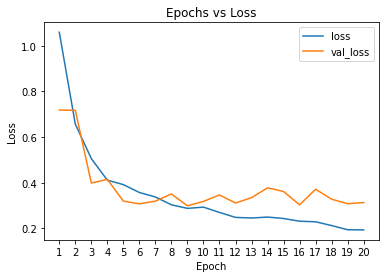

In [33]:
# Here is the code to visualize the loss values
sns.lineplot(x=range(1,21),y=history.history['loss'])
sns.lineplot(x=range(1,21),y=history.history['val_loss'])
plt.legend(loc='upper right',labels=['loss','val_loss'])
plt.title('Epochs vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.xticks(ticks=range(1,21));

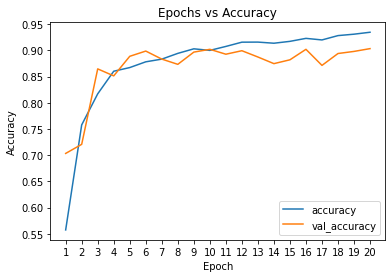

In [16]:
# Here is the code to visualize the accuracy values 
sns.lineplot(x=range(1,21),y=history.history['accuracy'])
sns.lineplot(x=range(1,21),y=history.history['val_accuracy'])
plt.legend(loc='lower right',labels=['accuracy','val_accuracy'])
plt.title('Epochs vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.xticks(ticks=range(1,21));

# Here we are going to visualize some of the response maps from the convolutions. 

In [18]:
# Here we are going to load the best version of the model and look at its convolutional maps
model = tf.keras.models.load_model('best_model.pb')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                41040     
_________________________________________________________________
dropout (Dropout)            (None, 80)                0     

In [30]:
# Here we are going to use vgg19 directly since we did not train the weights of the model.
viz_conv = Model(inputs=[vgg19.input],outputs=[vgg19.get_layer('block1_conv2').output])

In [34]:
# image we are going to use 
myimg = prepare_image(img_path='/content/drive/MyDrive/MSBA/BA885/data/val/forest/20089.jpg')
features0= viz_conv.predict(myimg)

#### Here we are visualizing the 64 different response maps

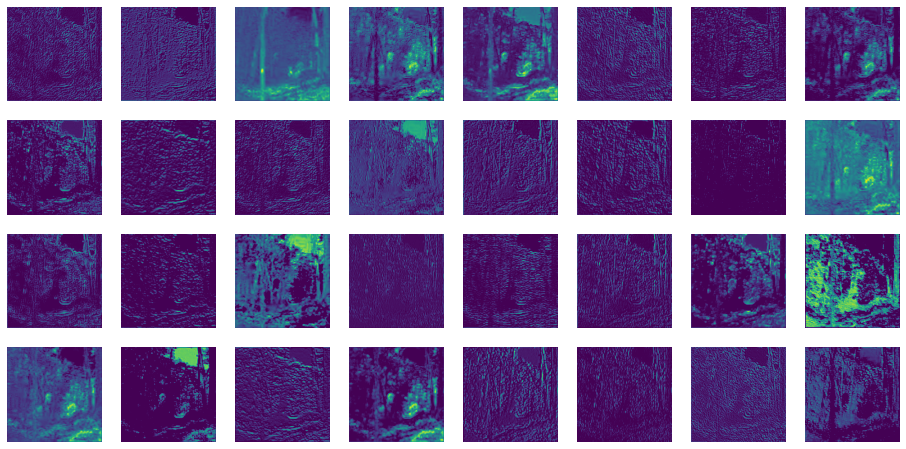

In [38]:
plt.figure(figsize=(16, 8))
N=32
for images in features0:
  for i in range(N):
    plt.subplot(4,8,i+1)
    plt.imshow(features0[0,:,:,i])
    #ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].astype("uint8"))
    #plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

shape:  (1, 224, 224, 64) 

type:  <class 'numpy.ndarray'> 



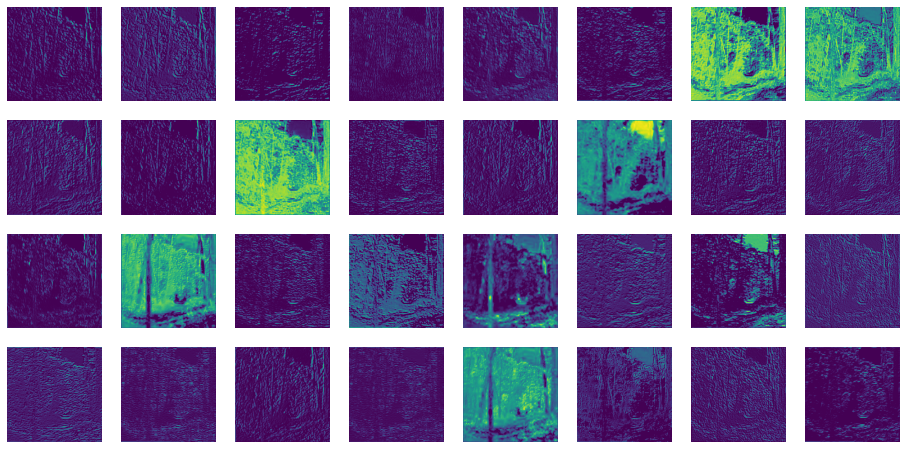

In [43]:
print('shape: ', features0.shape , '\n')
print('type: ',type(features0), '\n')
#Visualize the features
plt.figure(figsize=(16, 8))
N=32
for images in features0:
  for i in range(N):
    plt.subplot(4,8,i+1)
    plt.imshow(features0[0,:,:,i+32])
    #ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].astype("uint8"))
    #plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

[0. 0. 1. 0. 0. 0.]
True label is: glacier
Predictions:
[7.5587856e-09 4.3227050e-07 9.9995291e-01 4.5624791e-05 8.2309032e-07
 1.4271419e-07]
Predicted label is: glacier


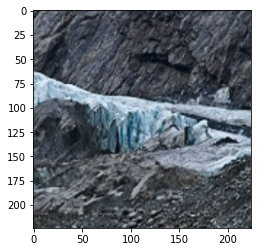

In [48]:
one_batch = next(iter(val_ds_labeled.take(2)))
#the true label
tlabel = one_batch[1][0].numpy()
print(tlabel)
print("True label is: {}".format(val_ds_labeled.class_names[np.argmax(tlabel)]))
#the image
plt.imshow(one_batch[0][0].numpy().astype("uint8"))
#run prediction
predictions = model.predict(one_batch[0])
print("Predictions:")
print(predictions[0])
print("Predicted label is: {}".format(val_ds_labeled.class_names[np.argmax(predictions[0])]))

In [49]:
bad_predictions=[]
for i in range(32):
  tl = np.argmax(one_batch[1][i].numpy())
  pl = np.argmax(predictions[i])
  if int(tl) != int(pl): 
    print("Example {}: True label {} Predicted label {}".format(i, tl,pl))
    bad_predictions.append(i)
print(bad_predictions)

Example 25: True label 5 Predicted label 0
[25]


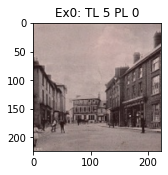

In [50]:
plt.figure(figsize=(16, 8))
for i,j in enumerate(bad_predictions):
  plt.subplot(3,3,i+1)
  plt.imshow(one_batch[0][j].numpy().astype("uint8"))
  plt.title("Ex{}: TL {} PL {}".format(i, np.argmax(one_batch[1][j].numpy()),
                                       np.argmax(predictions[j])))

In [66]:
# Here we are getting our predicted labels in label encoded format 
val_predictions = model.predict(val_ds_labeled)
val_predictions= np.argmax(val_predictions,axis=1)

In [83]:
val_true_labels = []
val_pred_labels = []
for x , y in val_ds_labeled:
  
  y_pred = model.predict_on_batch(x)
  y_pred = np.argmax(y_pred,axis=1).tolist()
  val_pred_labels.extend(y_pred)

  y_ = np.argmax(y,axis=1).tolist()
  val_true_labels.extend(y_)

In [88]:
print(f"Here we are the labels for the following classification report (0,..,5): {val_ds_labeled.class_names}")

Here we are the labels for the following classification report (0,..,5): ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [84]:
print(classification_report(val_true_labels,val_pred_labels))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       208
           1       1.00      0.98      0.99       242
           2       0.90      0.82      0.86       272
           3       0.85      0.89      0.87       280
           4       0.91      0.97      0.94       240
           5       0.93      0.87      0.90       258

    accuracy                           0.90      1500
   macro avg       0.90      0.91      0.90      1500
weighted avg       0.90      0.90      0.90      1500

